# _Moneyballing Fantasy Premier League Football_
# Exploratory Data Analysis

We spent a long time in the last notebook creating systems with which to gather our data.

Before we start creating predictive models, we should first explore the data, and see what patterns we can spot.

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np

#SQL
import sqlite3
#Including custom functions, stored elsewhere in the repo
from PythonFunctions.sqlfunctions import *

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

## High level visuals

Let's keep things relatively high level for now - first looking at the basic stats of teams and players in the game.

Firsly, we need to connect to the SQL database we built in the previous notebook.

In [2]:
#Connect to the database 'fpl.db' (fantasy premier league!)
conn = sqlite3.connect('Data/fpl.db')
#Instantiate a cursor
c = conn.cursor()

We can confirm that all the data pulled through as expected...

In [3]:
#Print the names of the tables in the SQL database
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

TeamsBasic
PlayersBasic
ShotsDetail
PlayerMatchesDetail
TeamMatchesDetail
FixturesBasic
TeamsXGC
PlayersXG
PlayerAPIStats
TeamsXG


In [4]:
df_teams = sql('SELECT * FROM TeamsBasic', c).head(20)
df_teams['TeamColor'] = df_teams['ShortName'].map(lambda x: team_colors[x])
df_teams.head()

,TeamID,Team,ShortName,Strength,CommentName,TeamColor
TeamsBasicID,,,,,,
1,1,Arsenal,ARS,4,Arsenal,#EF0107
2,2,Aston Villa,AVL,2,Aston Villa,#770038
3,3,Bournemouth,BOU,3,Bournemouth,#D3151B
4,4,Brighton,BHA,3,Brighton and Hove Albion,#005DAA
5,5,Burnley,BUR,3,Burnley,#630F33


In [5]:
df_players = sql('SELECT * FROM PlayersBasic', c)
df_players.head()

,PlayerID,PlayerCode,FirstName,WebName,Team,Position,CommentName
PlayersBasicID,,,,,,,
1,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
2,2,98745,Hector,Bellerin,Arsenal,DEF,Hector Bellerin
3,3,111457,Sead,Kolasinac,Arsenal,DEF,Sead Kolasinac
4,4,154043,Ainsley,Maitland-Niles,Arsenal,DEF,Ainsley Maitland-Niles
5,5,39476,Sokratis,Sokratis,Arsenal,DEF,Sokratis


### Squad Sizes

We can see that on average teams have around 30 players in their squads (remember that for each game, a team has a 'match-day squad' of 18 (11 starters plus 7 substitutes). However, there is some variance, with some teams having as few as 25 players.

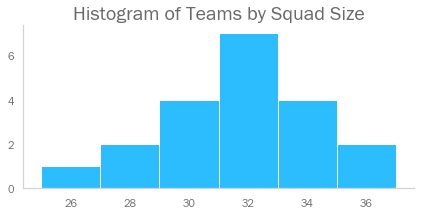

In [6]:
plt.figure(figsize=(7,3))
plt.hist(df_players.groupby('Team').count()['PlayerID'], bins=6)
plt.title('Histogram of Teams by Squad Size');

If we break down the player squads, we can see that midfielders and defenders are the most common role. As we would expect, goalkeepers are the least common type of player (given that a team can only field one such player during a game).

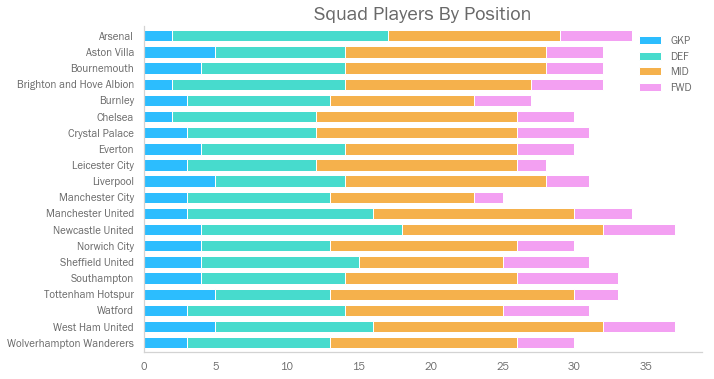

In [7]:
players_pivot = df_players.pivot_table(index='Team',
                                       columns='Position',
                                       aggfunc='count')['CommentName']

players_pivot[['GKP','DEF','MID','FWD']][::-1].plot.barh(stacked=True,
                                                         figsize=(10,6),
                                                         width=0.7);
plt.title('Squad Players By Position');
plt.ylabel('')
plt.legend(frameon=False);

We also note there are some teams with very few 'recognised' forwards players. This is even true of Manchester City, the team that scored the most goals in the 2018/19 season.

Here we see a typical Manchester City line up. Aguero is the only 'recognised' striker, however other midfielders such as Sterling and Silva are played in a very advanced position. This is important context - given their positions they are still likely to score, though in FPL each of their goals earn more points than 'recognised' strikers (7 vs. 6).

![title](Images/CityLineup.jpg)

### Player Stats

Let's now get more granular at a player level.

Firstly, let's import some player data from the SQL database.

In [8]:
df_players = sql('''SELECT * FROM PlayerAPIStats
                    JOIN PlayersBasic
                    USING(PlayerID)''', c)
df_players.head()

,TableIndex,BPS,CleanSheet,Date,GameWeek,MinutesPlayed,NetTransfersIn,PlayerID,Points,Price,Saves,SelectedBy,PlayersBasicID,PlayerCode,FirstName,WebName,Team,Position,CommentName
PlayerAPIStatsID,,,,,,,,,,,,,,,,,,,
1,0,0,0.0,2019-08-11,1,0.0,0,1,0,5.5,0.0,33117,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
2,1,0,0.0,2019-08-17,2,0.0,-5280,1,0,5.5,0.0,36709,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
3,2,0,0.0,2019-08-24,3,0.0,-6882,1,0,5.4,0.0,30975,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
4,3,0,0.0,2019-09-01,4,0.0,-3872,1,0,5.4,0.0,28096,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
5,4,0,0.0,2019-09-15,5,0.0,-2073,1,0,5.3,0.0,26902,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi


Let's create a function to look at the distribution of player KPIs at various points in the season.

In [9]:
def kpi_kde(week, kpi, minutes=45, positions=None, size=(10,4), title=None, df=df_players):
    '''
    Takes a gameweek, a kpi, a minutes threshold, and a list of positions,
    and outputs a chart showing KDEs for the given kpi
    '''
    #Check if week is given as a list
    if type(week)!=list:
        week = [week]
    
    if positions == None:
        positions = ['GKP','DEF','MID','FWD']
    
    plt.figure(figsize=size)
    color_count = 0
    for i in week:
        for j in positions:
            X = df_players.loc[(df['MinutesPlayed']>=minutes)
                              &(df['Position']==j)
                              &(df['GameWeek']==i)
                              ][kpi]
            label = f'{j}, gameweek {i}'
            sns.kdeplot(X, color=color_list[color_count],
                        label=label, lw=3)
            color_count += 1
            
    if title==None:
        plt.title(f'KDE for Player {kpi}')
    else:
        plt.title(title)

    plt.xlabel(f'Player {kpi}')

    plt.ylim(0,)
    plt.yticks([])
    sns.despine(left=True)
    
    plt.legend(frameon=False)

Firstly, we see that player prices vary significantly depending on position, with goalkeepers and defenders priced much more cheaply than attacking options such as midfielders and forwards.

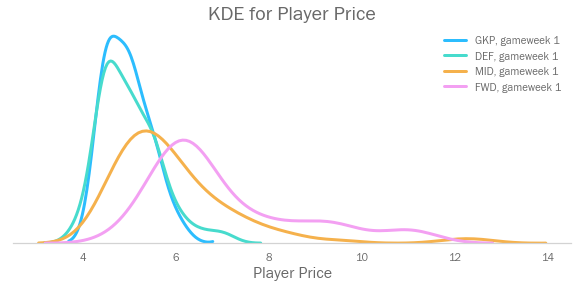

In [10]:
kpi_kde(1,'Price')

Though as it turned out in the first game week, the number of points that players got for their fantasy teams was much less clear cut - goalkeepers and defenders were more likely to get a middling number of points (both positions are awarded 6 points for keeping a clean sheet), whereas midfielders and attackers were more likely to have low scores (with a small number of players scoring many points). 

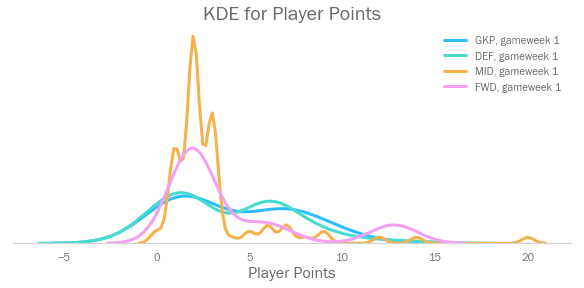

In [11]:
kpi_kde(1,'Points')

Of course, it's worthwhile checking how the relationship between points and price looked over the season so far.

In [12]:
def jointplot(X, Y, week=None, title=None,
              positions=None, height=6,
              xlim=None, ylim=None, cut=0.015,
              color=CB91_Blue, levels=30, bw=0.5, top_rows=100000):
    
    if positions == None:
        positions = ['GKP','DEF','MID','FWD']
        
    #Check if week is given as a list
    if week == None:
        week = list(range(max(df_players['GameWeek'])))
    
    if type(week)!=list:
        week = [week]
        
    df_played = df_players.loc[(df_players['MinutesPlayed']>=45)
                              &(df_players['GameWeek'].isin(week))
                              &(df_players['Position'].isin(positions))].head(top_rows)   
    
    if xlim == None:
        xlim = (df_played[X].quantile(cut),
                df_played[X].quantile(1-cut))
        
    if ylim == None:
        ylim = (df_played[Y].quantile(cut),
                df_played[Y].quantile(1-cut))

    sns.jointplot(X, Y, data=df_played,
                  kind="kde", xlim=xlim, ylim=ylim,
                  color=color, n_levels=levels,
                  height=height, bw=bw);
    
    plt.suptitle(title,fontsize=18);

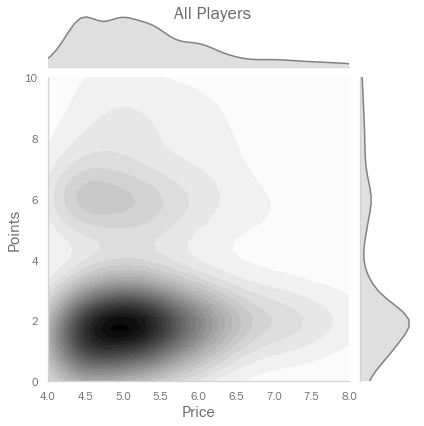

In [13]:
jointplot('Price', 'Points',  xlim=(4,8), ylim=(0,10),
          color='grey', title='All Players', bw=None)

Looking at goalkeepers in isolation, we see that 6 points is a common score to get (it is the score for keeping a clean sheet). Though we see a slight shading at the more expensive end of the scale, there are clearly players between 4.6-5.0m scoring well as well.

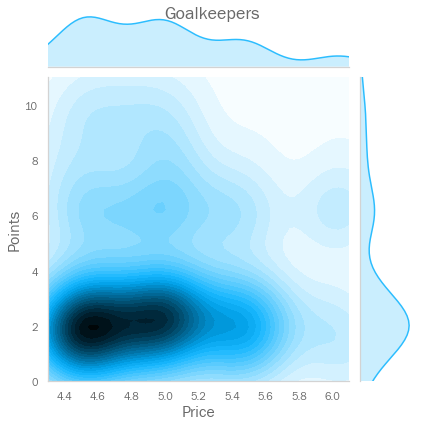

In [14]:
jointplot('Price', 'Points', positions=['GKP'],
          color=color_list[0], title='Goalkeepers', bw=None)

A similar story plays out for defenders - there are cheap players scoring well.

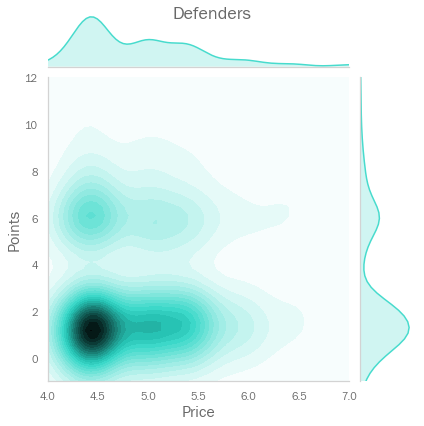

In [15]:
jointplot('Price', 'Points', positions=['DEF'],
          color=color_list[1], title='Defenders', bw=None)

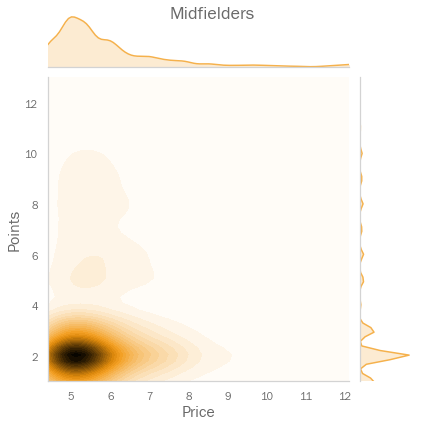

In [16]:
jointplot('Price', 'Points', positions=['MID'],
          color=color_list[2], title='Midfielders', bw=0.5)

Forwards are the position that hint the most at a positive correlation between price and points, though as with the other positions there are clearly cheaper players who are scoring 6-10 points in a game.

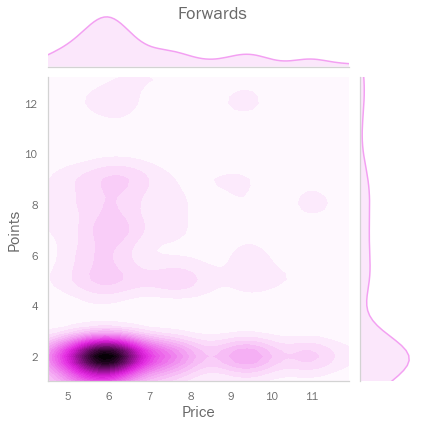

In [17]:
jointplot('Price', 'Points', positions=['FWD'],
          color=color_list[3], title='Forwards')

It's not obvious that you need to pay more to get more points out of your players. In particular, in all of these plots there is a distinct 'blob' directly above the average price - players who are scoring lots of nice FPL points without breaking the bank.

### Understanding Player Value

We have evidence that there are cheap players in the game that can score points as effectively as expensive players. Let's try and get a sense of player value to try and make this a bit more mathematical.

Firstly, let's take a very crude 'points per pound' approach.

In [18]:
X = df_players.loc[(df_players['MinutesPlayed']>=45)]['Price']
Y = df_players.loc[(df_players['MinutesPlayed']>=45)]['Points']
df_players['PointsPerPrice'] = df_players['Points'] / df_players['Price']

We can see that the vast majority of players score between 0.3 and 1.2 points per million value per game. This should be expected, given the average weekly score and average value of players in the game.

(Note, here we only use game weeks where players play at least half the game. Later we will explore all matches, including where players do not play, since their not playing has a direct impact on their price, and thus their value as a member of a fantasy team.)

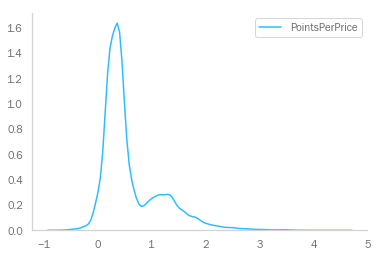

In [19]:
sns.kdeplot(df_players.loc[df_players['MinutesPlayed']>=45]['PointsPerPrice']);

In [20]:
print('Average Price:',
      round(df_players.loc[(df_players['MinutesPlayed']>=45)]['Price'].mean(),2))
print('Average Points Per Game:',
      round(df_players.loc[(df_players['MinutesPlayed']>=45)]['Points'].mean(),2))

Average Price: 5.58
Average Points Per Game: 3.33


It's worth noting that the standard deviation for a player on a game by game basis is quite high in the context of the range shown in the KDE above.

In [21]:
df_players.groupby('CommentName').std()['PointsPerPrice'].mean()

0.2978244971045222

Let's consider the average points per pound over the course of a season. This will now include instances where players have missed games, scoring zero points in that game week.

In [22]:
#Build out a new dataframe to investigate points per price
PPP_mean = df_players.groupby('CommentName').mean()['PointsPerPrice']
PPP_std = df_players.groupby('CommentName').std()['PointsPerPrice']
PPG_mean = df_players.groupby('CommentName').mean()['Points']
Price_mean = df_players.groupby('CommentName').mean()['Price']
Selected_mean = df_players.groupby('CommentName').mean()['SelectedBy']
position = df_players.groupby('CommentName')['Position'].agg(pd.Series.mode)
total_minutes = df_players.groupby('CommentName').sum()['MinutesPlayed']
total_points = df_players.groupby('CommentName').sum()['Points']

df_ppp = pd.DataFrame([PPP_mean,PPP_std,PPG_mean,Price_mean,Selected_mean,
                       total_minutes,total_points,position]).T

df_ppp.columns = ['MeanPPP','StdPPP','MeanPPG','MeanPrice','MeanSelected',
                  'TotalMinutes','TotalPoints','Position']

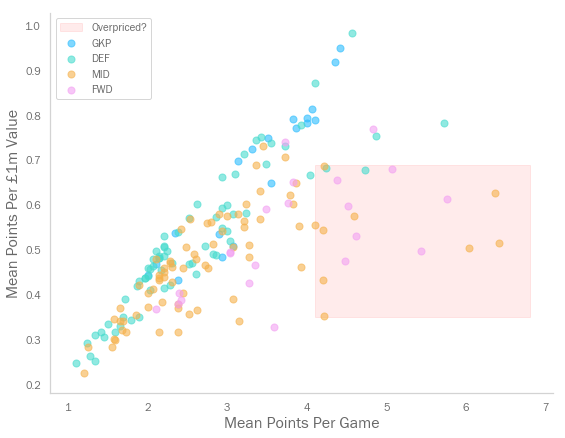

In [23]:
plt.figure(figsize=(9,7))

plt.fill_between([4.1,6.8],[0.35,0.35],[0.69,0.69],
                 alpha=0.08,color='red')

#For each position
for n, i in enumerate(['GKP','DEF','MID','FWD']):
    #Isolate the players in that position
    df_temp = df_ppp.loc[(df_ppp['TotalMinutes']>=60*24)
                        &(df_ppp['Position']==i)]
    X = df_temp['MeanPPG']
    Y = df_temp['MeanPPP']
    plt.scatter(X, Y, s=50, c=color_list[n], alpha=0.6)

plt.xlabel('Mean Points Per Game')
plt.ylabel('Mean Points Per £1m Value')
plt.legend(loc=2, labels=['Overpriced?','GKP','DEF','MID','FWD']);

In [24]:
df_ppp.loc[(df_ppp['TotalMinutes']>=60*24)
          &(df_ppp['MeanPPG']>3.5)
          &(df_ppp['MeanPPP']>0.7)].sort_values('TotalPoints',
                                                ascending=False).head(20)

,MeanPPP,StdPPP,MeanPPG,MeanPrice,MeanSelected,TotalMinutes,TotalPoints,Position
CommentName,,,,,,,,
Trent Alexander-Arnold,0.782939,0.641793,5.72414,7.31724,2.33717e+06,2549,166,DEF
Virgil van Dijk,0.754328,0.615426,4.86207,6.46207,3.08476e+06,2610,141,DEF
Danny Ings,0.769892,0.57095,4.82759,6.36897,908457,1993,140,FWD
Nick Pope,0.949339,0.763131,4.41379,4.65517,977002,2610,128,GKP
John Lundstram,0.983083,1.12432,4.57143,4.76429,2.64659e+06,2065,128,DEF
Dean Henderson,0.918276,0.665083,4.35714,4.73571,513352,2430,122,GKP
Kasper Schmeichel,0.788555,0.503844,4.10345,5.21724,820534,2610,119,GKP
Martin Dubravka,0.813793,0.509709,4.06897,5,86926.8,2610,118,GKP
Vicente Guaita,0.792563,0.667895,4,5.04483,114375,2430,116,GKP


So we've isolated the players that were the 'best value'.

Suppose we'd have chosen these players as a team at the start of the season, and just played them again and again. How would our season have looked?

For a start, it would have cost £65m. Even assuming you then have four £4m players to bulk out your squad to 15, as is required in FPL, this still leaves a comfortable £19m spare cash.

It's also worth noticing that the same set of 11 players would now cost £91.6m - a colossal increase in 24 weeks.

In [25]:
value_team = ['Dean Henderson',
              'Trent Alexander-Arnold','Virgil van Dijk','Andrew Robertson',
              'John Lundstram','Adama Traore','Jack Grealish','Todd Cantwell',
              'Raul Jimenez','Tammy Abraham','Danny Ings']

value_team_df = df_players.loc[df_players['CommentName'].isin(value_team)]

print('Value team week 1 value:',
      value_team_df.loc[value_team_df['GameWeek']==1]['Price'].sum())

print('Value team week 24 value:',
      round(value_team_df.loc[value_team_df['GameWeek']==24]['Price'].sum(),1))

Value team week 1 value: 65.0
Value team week 24 value: 91.6


The team would have also got you around 1,300-1,400 points (depending on how effectively the captain chip, which doubles the points of a single chosen player in a given gameweek, is played).

This would currently mean a global rank of c.141,300 out of over 7,000,000 players - i.e. in the top 2%.

In [26]:
int(value_team_df['Points'].sum()*(12/11))

1568

Of course, sticking with the same team for the whole season is a suboptimal way to play the game.

Different players come into form at different times of the season, while some teams will have runs of tough fixtures that depress their scores on a weekly basis.

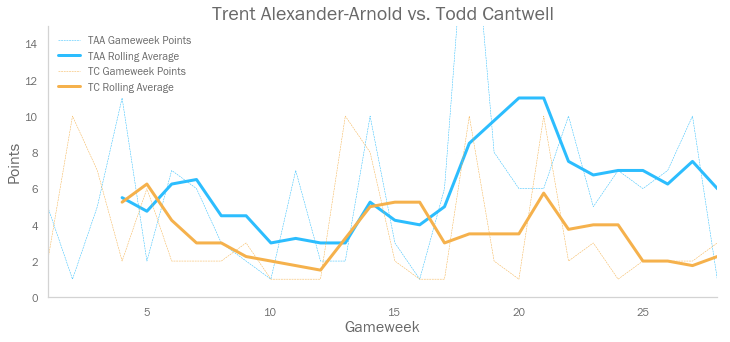

In [27]:
taa_points = df_players.loc[df_players['CommentName']=='Trent Alexander-Arnold'][['Points']]
taa_points['RollingAvg'] = taa_points.rolling(window=4, center=False).mean()

tc_points = df_players.loc[df_players['CommentName']=='Todd Cantwell'][['Points']]
tc_points['RollingAvg'] = tc_points.rolling(window=4, center=False).mean()


plt.figure(figsize=(12,5))

Y1 = taa_points['Points']
Y2 = taa_points['RollingAvg']
Y3 = tc_points['Points']
Y4 = tc_points['RollingAvg']
X = max(len(Y1),len(Y3))+1

plt.plot(range(1,X), Y1, label='TAA Gameweek Points', lw=0.5, ls='--')
plt.plot(range(1,X), Y2, label='TAA Rolling Average', lw=3, color=CB91_Blue)
plt.plot(range(1,X), Y3, label='TC Gameweek Points', lw=0.5, ls='--', color=CB91_Amber)
plt.plot(range(1,X), Y4, label='TC Rolling Average', lw=3, color=CB91_Amber)

plt.xlabel('Gameweek')
plt.ylabel('Points')
plt.title('Trent Alexander-Arnold vs. Todd Cantwell')

plt.xlim(1,X-2)
plt.ylim(0,15)

plt.legend(loc=2, frameon=False);

This further justifies our desire to predict player performance on a week by week basis.

### Investigating FPL Economics

As we saw previously, the collective price of players in our 'value' team increased by over 40%. This is an extreme example of the 'market forces' aspect of FPL, where the transferring in and out of players by FPL managers causes fluctuations in the players' prices.

Let's investigate this further by creating a column showing price fluctuations week to week.

In [28]:
def price_change(PlayerID, GameWeek):
    if GameWeek==1:
        return 0
    else:
        player_df = df_players.loc[df_players['PlayerID']==PlayerID]
        
        prev_price = player_df.loc[player_df['GameWeek']==(GameWeek-1),'Price'].item()
        current_price = player_df.loc[player_df['GameWeek']==(GameWeek),'Price'].item()
        
        return round(current_price-prev_price,1)

We can add this as a new column in our dataframe.

In [29]:
price_changes = []

for i in range(len(df_players)):
    player = df_players.iloc[i]['PlayerID']
    week = df_players.iloc[i]['GameWeek']
    try:
        price_changes.append(price_change(player, week))
    except:
        price_changes.append(0)
    
df_players['PriceChange'] = price_changes

Though there are outliers in each category (excluded from the below visualisation), we can see that there are fairly distinct boundaries for what ranges of net transfers result in what kinds of price changes.

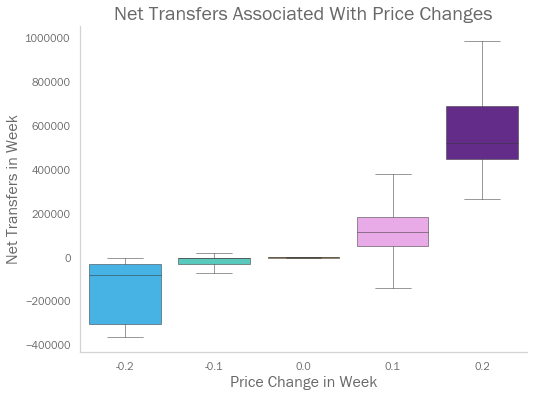

In [30]:
df_price_changes = df_players.loc[df_players['GameWeek']>1]

plt.figure(figsize=(8,6))
sns.boxplot('PriceChange','NetTransfersIn',
            data=df_price_changes,
            linewidth=0.5,showfliers=False);

plt.title('Net Transfers Associated With Price Changes')
plt.xlabel('Price Change in Week')
plt.ylabel('Net Transfers in Week');

So what drives net transfers? Let's create a function that gives us the next week's net transfers, based on the performance of the player in the current week.

In [31]:
def nextweek_transfers(PlayerID, GameWeek, lastgw=24):
    if GameWeek==lastgw:
        return 'Null'
    else:
        player_df = df_players.loc[df_players['PlayerID']==PlayerID]
        return player_df.loc[player_df['GameWeek']==(GameWeek+1),
                                  'NetTransfersIn'].item()

In [32]:
next_net_transfers = []

for i in range(len(df_players)):
    player = df_players.iloc[i]['PlayerID']
    week = df_players.iloc[i]['GameWeek']
    try:
        next_net_transfers.append(nextweek_transfers(player, week))
    except:
        next_net_transfers.append('Null')
    
df_players['NextNetTransfersIn'] = next_net_transfers

We see a positive correlation between how a player does in a game, vs. the net transfers the following week.

However, the correlation isn't especially strong when we look at all the players in conjunction.

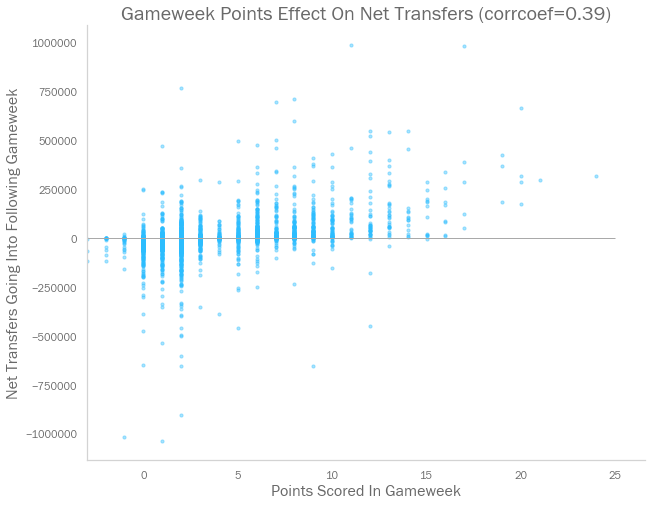

In [33]:
plt.figure(figsize=(10,8))

#Consider only players that play at least semi-regularly for the first team
active_players = list(df_ppp.loc[df_ppp['TotalMinutes']>24*45].index)

df_temp = df_players.loc[(df_players['GameWeek']<24)
                        &(df_players['CommentName'].isin(active_players))
                        &(df_players['NextNetTransfersIn']!='Null')]
X = df_temp['Points']
Y = df_temp['NextNetTransfersIn']

cor = np.corrcoef(X,Y.astype(float))[0][1]

plt.hlines(0,-5,25,color='darkgrey',lw=1)
plt.scatter(X,Y,alpha=0.4,s=10);
plt.xlim(-3,)

plt.title(f"Gameweek Points Effect On Net Transfers (corrcoef={round(cor,3)})")
plt.xlabel("Points Scored In Gameweek")
plt.ylabel("Net Transfers Going Into Following Gameweek");

However, when we look at the players sorted by position, we see clearer correlations. The goalkeepers, who are transfered less frequently, are less elastic (note the one exception - Liverpool's highly selected goalkeeper Alisson, who sustained a long-term injury, causing a mass sell-off the following week).

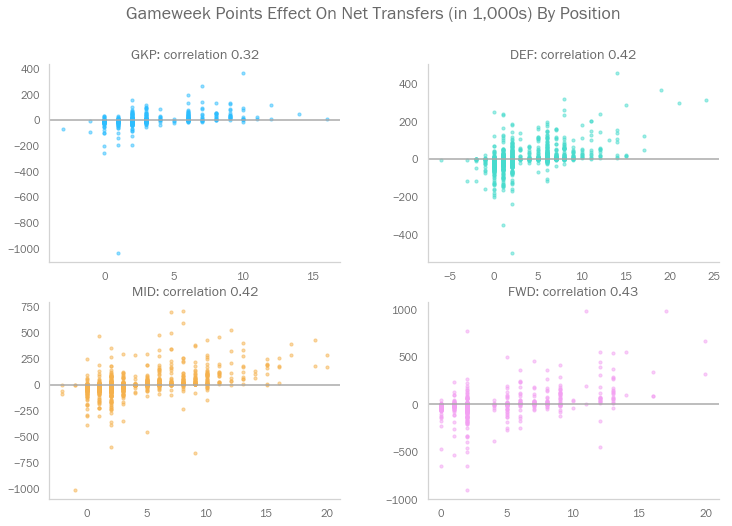

In [34]:
#Consider only players that play at least semi-regularly for the first team
active_players = list(df_ppp.loc[df_ppp['TotalMinutes']>24*45].index)

df_temp = df_players.loc[(df_players['GameWeek']<24)
                        &(df_players['CommentName'].isin(active_players))
                        &(df_players['NextNetTransfersIn']!='Null')]

c = ['GKP','DEF','MID','FWD']
l = len(c)
n = 2

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12,8))

fig.subplots_adjust(hspace=0.2, wspace=0.3)

for a in range(l):
    df_pos = df_temp.loc[df_temp['Position']==c[a]]
    X = df_pos['Points']
    Y = df_pos['NextNetTransfersIn']/1000
    cor = np.corrcoef(X,Y.astype(float))[0][1]

    ax = axes[a//n][a%n]
    ax.axhline(y=0, color='darkgrey')
    ax.scatter(X,Y,color=color_list[a],alpha=0.5,s=10)
    
    ax.set_title(f'{c[a]}: correlation {round(cor,2)}', fontsize=14)
    
plt.suptitle('Gameweek Points Effect On Net Transfers (in 1,000s) By Position',
            fontsize=18);

Interestingly, very similar correlations are observed when we look at points per price as the input feature - apart from for midfielders.

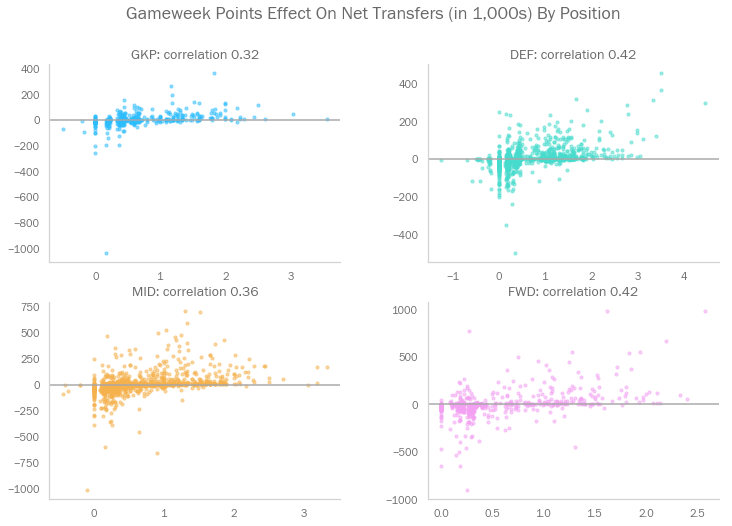

In [35]:
#Consider only players that play at least semi-regularly for the first team
active_players = list(df_ppp.loc[df_ppp['TotalMinutes']>24*45].index)

df_temp = df_players.loc[(df_players['GameWeek']<24)
                        &(df_players['CommentName'].isin(active_players))
                        &(df_players['NextNetTransfersIn']!='Null')]

c = ['GKP','DEF','MID','FWD']
l = len(c)
n = 2

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12,8))

fig.subplots_adjust(hspace=0.2, wspace=0.3)

for a in range(l):
    df_pos = df_temp.loc[df_temp['Position']==c[a]]
    X = df_pos['PointsPerPrice']
    Y = df_pos['NextNetTransfersIn']/1000
    cor = np.corrcoef(X,Y.astype(float))[0][1]

    ax = axes[a//n][a%n]
    ax.axhline(y=0, color='darkgrey')
    ax.scatter(X,Y,color=color_list[a],alpha=0.5,s=10)
    
    ax.set_title(f'{c[a]}: correlation {round(cor,2)}', fontsize=14)
    
plt.suptitle('Gameweek Points Effect On Net Transfers (in 1,000s) By Position',
            fontsize=18);

This may be due to the fact that the game has more expensive midfielders (many of whom, admittedly, are scoring succesfully over the course of the season).

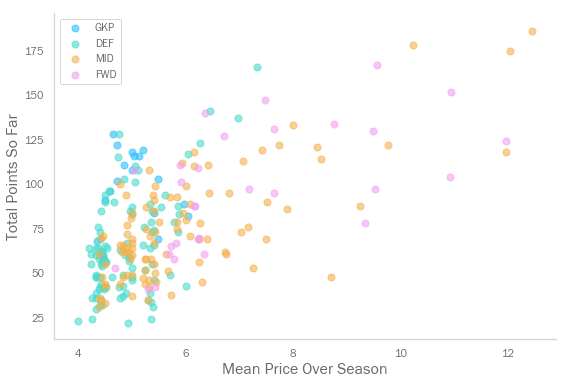

In [36]:
plt.figure(figsize=(9,6))

#For each position
for n, i in enumerate(['GKP','DEF','MID','FWD']):
    #Isolate the players in that position
    df_temp = df_ppp.loc[(df_ppp['TotalMinutes']>=45*24)
                        &(df_ppp['Position']==i)]
    X = df_temp['MeanPrice']
    Y = df_temp['TotalPoints']
    plt.scatter(X, Y, s=50, c=color_list[n], alpha=0.6)

plt.xlabel('Mean Price Over Season')
plt.ylabel('Total Points So Far')
plt.legend(loc=2, labels=['GKP','DEF','MID','FWD']);

### Investigating Player Price Changes

We see below that, as previously explored, the 'value' players have generally increased in price through the season (though some did initially fall, following weaker performances).

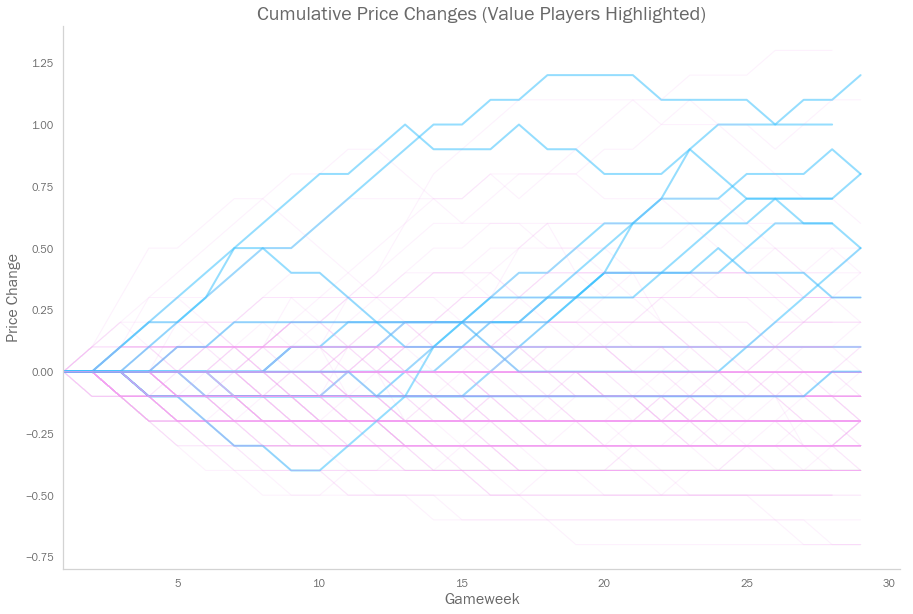

In [37]:
plt.figure(figsize=(15,10))

for i in active_players:
    df_temp = df_players.loc[df_players['CommentName']==i]
    to_plot = df_temp['PriceChange'].cumsum()
    X = range(1,len(to_plot)+1)
    
    c = CB91_Pink
    alpha = 0.15
    lw = 1
    if i in value_team:
        c = CB91_Blue
        lw = 2
        alpha = 0.5
        
    plt.plot(X, to_plot,
             color=c, lw=lw, alpha = alpha)

plt.xlim(1,)
plt.title('Cumulative Price Changes (Value Players Highlighted)')
plt.xlabel('Gameweek')
plt.ylabel('Price Change');

How has this changed by team?

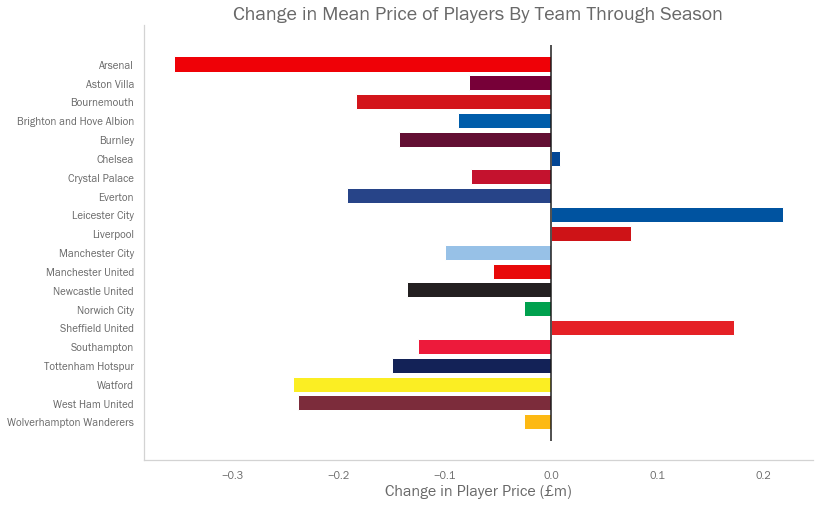

In [38]:
df_active = df_players.loc[df_players['CommentName'].isin(active_players)]
gw_prices = df_active.groupby(['Team','GameWeek']).mean()

plt.figure(figsize=(12,8))

teams = list(df_players['Team'].unique())

Y = []
for i in teams:
    Y.append(gw_prices.loc[i,'Price'][25] - gw_prices.loc[i,'Price'][1])
    
X = range(1,len(Y)+1)
c = [i[1] for i in team_colors.items()]

plt.vlines(0,0,21)
plt.barh(X[::-1],Y,color=c)

plt.yticks(np.arange(1,21),labels=teams[::-1])
plt.xlabel('Change in Player Price (£m)')
plt.title('Change in Mean Price of Players By Team Through Season');

Broadly speaking, we can see that teams have lost value on average, with some notable exceptions - Liverpool's players started expensive, and have become moreso as they have outclassed all other teams; Leicester had an unexpected run of form in the first half of the season; Sheffield United had many cheap players, and outperformed expecations, especially given that they were newly promoted to the division.

On the other end of the scale, Arsenal have failed to live up to expectations as a potential title-winning side, whilst Watford and West Ham have spent time battling relegation - a significant regression from last season.

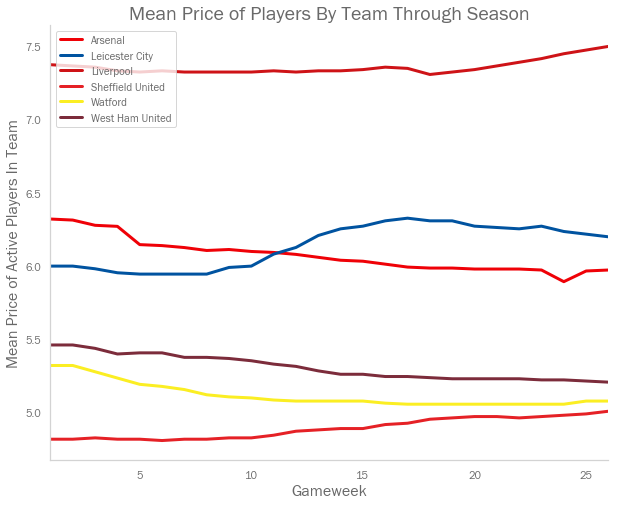

In [39]:
df_active = df_players.loc[df_players['CommentName'].isin(active_players)]
gw_prices = df_active.groupby(['Team','GameWeek']).mean()

plt.figure(figsize=(10,8))

highlighted_teams = ['Liverpool', 'Leicester City', 'Sheffield United',
                    'Arsenal', 'Watford', 'West Ham United']

for n, i in enumerate(list(df_players['Team'].unique())):
    if i in highlighted_teams:
        Y = gw_prices.loc[i,'Price']
        X = range(1,len(Y)+1)
        c = [i[1] for i in team_colors.items()][n]
        plt.plot(X,Y,c,lw=3,label=i)

plt.xlim(1,26)
plt.xlabel('Gameweek')
plt.ylabel('Mean Price of Active Players In Team')
plt.title('Mean Price of Players By Team Through Season')
plt.legend(loc=2);

## Differential Picks

Though we have considered player prices in some detail, the real knack of FPL is choosing players that do well, but aren't selected by many people.

Consider two players of different value, say John Lundstram at £4.8m, and Raheem Sterling at £12.0m. They might both score 15 points in a game week. Whilst we might feel proud for owning John Lundstram, whose points per price is going to be very strong that week, this is fairly meaningless if 50% of all FPL managers also own him - we aren't scoring many points relative to other players.

To that end, let's spend some time exploring the 'Selected by' metric.

If we look at the distribution of this metric, we generally see that most players are barely selected by any managers - we then have some players that are heavily selected, in some cases by nearly half of the managers in the game.

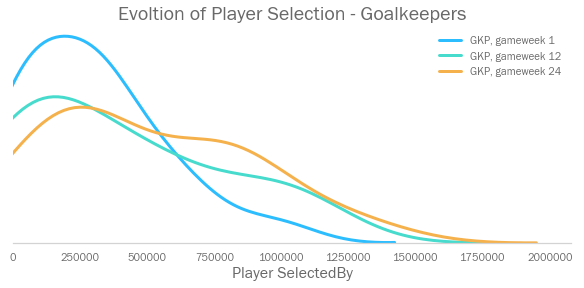

In [40]:
kpi_kde([1,12,24],'SelectedBy',positions=['GKP'],
        title='Evoltion of Player Selection - Goalkeepers')
plt.xlim(0,);

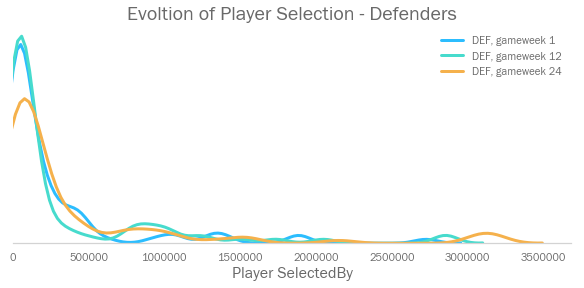

In [41]:
kpi_kde([1,12,24],'SelectedBy',positions=['DEF'],
        title='Evoltion of Player Selection - Defenders')
plt.xlim(0,);

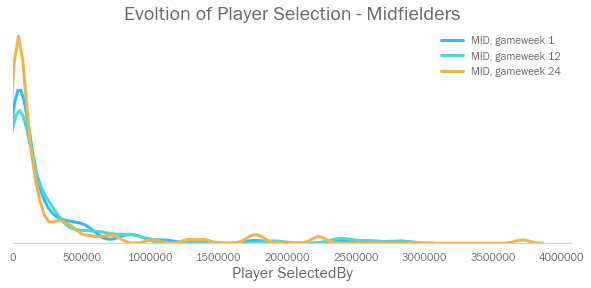

In [42]:
kpi_kde([1,12,24],'SelectedBy',positions=['MID'],
        title='Evoltion of Player Selection - Midfielders')
plt.xlim(0,);

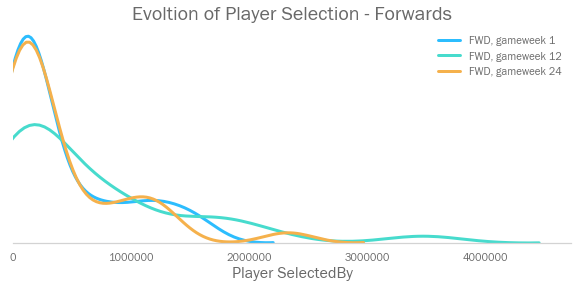

In [43]:
kpi_kde([1,12,24],'SelectedBy',positions=['FWD'],
        title='Evoltion of Player Selection - Forwards')
plt.xlim(0,);

We can see that for most positions (all but strikers, in fact), player selection generally got more concentrated over the course of the season so far.

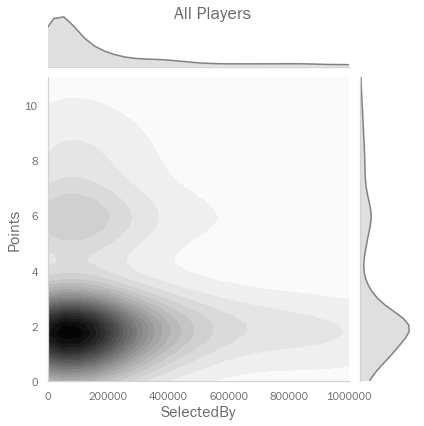

In [44]:
jointplot('SelectedBy', 'Points',
          color='grey', title='All Players',
          xlim=(0,1000000),ylim=(0,11), bw=None)

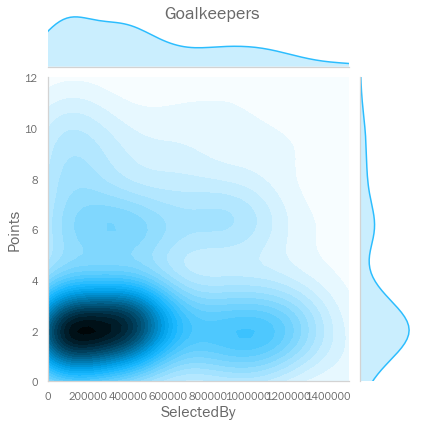

In [45]:
jointplot('SelectedBy', 'Points', positions=['GKP'],
          color=CB91_Blue, title='Goalkeepers',
          xlim=(0,1500000),ylim=(0,12), bw=None)

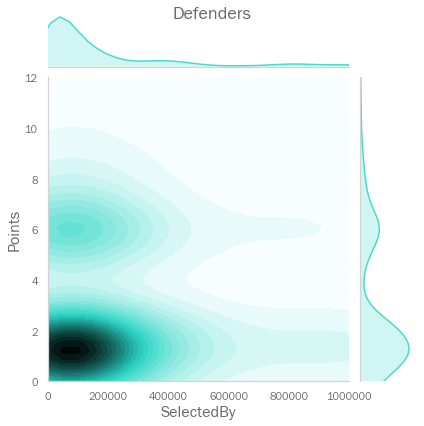

In [46]:
jointplot('SelectedBy', 'Points', positions=['DEF'],
          color=CB91_Green, title='Defenders',
          xlim=(0,1000000),ylim=(0,12), bw=None)

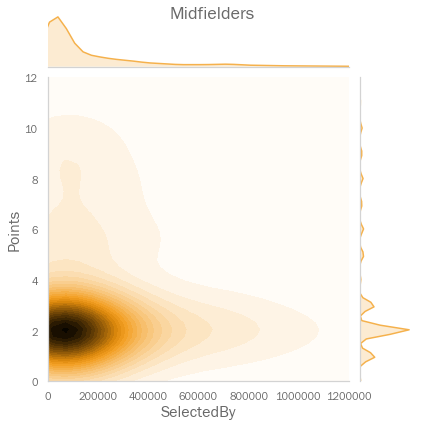

In [47]:
jointplot('SelectedBy', 'Points', positions=['MID'],
          color=CB91_Amber, title='Midfielders',
          xlim=(0,1200000), ylim=(0,12), top_rows=10000, bw=None)

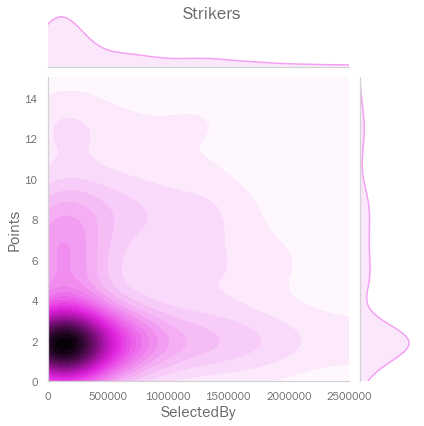

In [48]:
jointplot('SelectedBy', 'Points', positions=['FWD'],
          color=CB91_Pink, title='Strikers',
          xlim=(0,2500000),ylim=(0,15), bw=None)

So as with the comparison between price and points scored, we can see that lowly selected players have the potential to score big. Let's now consider the relationship between price and selected by.

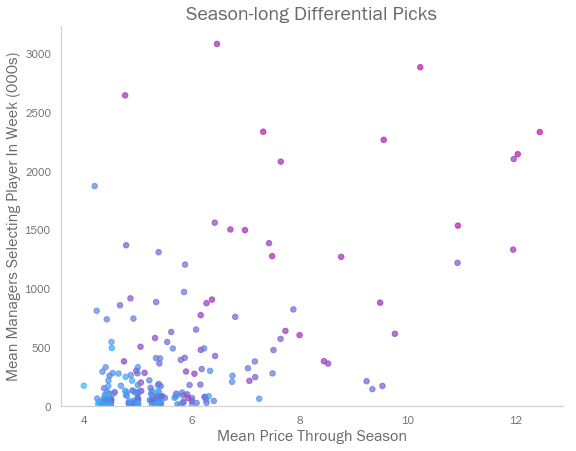

In [49]:
plt.figure(figsize=(9,7))

df_temp = df_ppp.loc[(df_ppp['TotalMinutes']>=45*25)
                    &(df_ppp['Position']!='GKP')]
X = df_temp['MeanPrice']
Y = df_temp['MeanSelected']/1000
C = gradient_mapper(df_temp['MeanPPG'], outliers='top',
                    grad=CB91_Grad_BP, stretch=2)[0]
plt.scatter(X, Y, s=30, c=C, alpha=0.7)

plt.xlabel('Mean Price Through Season')
plt.ylabel('Mean Managers Selecting Player In Week (000s)')
plt.ylim(0,)
plt.title('Season-long Differential Picks');

This is another clear example of how differential picks are there for the taking - though players with high prices and high ownership have scored consistently highly through the season (shown with the purple dots), there are players with low prices and low selection who have 'snuck under the radar'.

This is clearer if we zoom in on the bottom left corner of this chart.

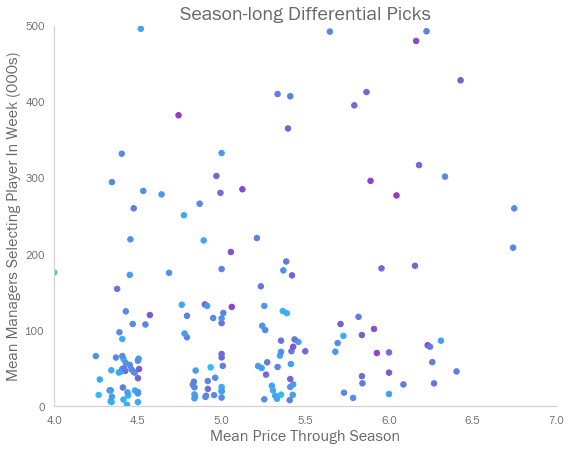

In [50]:
plt.figure(figsize=(9,7))

df_temp = df_ppp.loc[(df_ppp['TotalMinutes']>=45*25)
                    &(df_ppp['Position']!='GKP')]
X = df_temp['MeanPrice']
Y = df_temp['MeanSelected']/1000
C = gradient_mapper(df_temp['MeanPPG'], outliers='top',
                    grad=CB91_Grad_BP, stretch=2)[0]
plt.scatter(X, Y, s=30, c=C)

plt.xlabel('Mean Price Through Season')
plt.ylabel('Mean Managers Selecting Player In Week (000s)')
plt.ylim(0,500)
plt.xlim(4,7)
plt.title('Season-long Differential Picks');

In [51]:
low_select = df_temp.loc[(df_temp['MeanPrice']<6)
           &(df_temp['MeanSelected']<500000 )].sort_values('TotalPoints',
                                                           ascending=False).head(11)
low_select

,MeanPPP,StdPPP,MeanPPG,MeanPrice,MeanSelected,TotalMinutes,TotalPoints,Position
CommentName,,,,,,,,
George Baldock,0.872154,0.648822,4.10714,4.74286,382418,2520,115,DEF
Harvey Barnes,0.649681,0.716905,3.86207,5.92759,69989.8,1705,112,MID
Dominic Calvert-Lewin,0.650174,0.621419,3.82759,5.88966,296250,1904,111,FWD
Enda Stevens,0.777171,0.532633,3.92857,5.06071,130615,2445,110,DEF
Jonny Evans,0.730435,0.640267,3.72414,5.12414,285157,2574,108,DEF
James Tarkowski,0.690467,0.811329,3.48276,5.05517,202746,2610,101,DEF
Neal Maupay,0.590365,0.493161,3.48276,5.91034,101637,2109,101,FWD
Jordan Henderson,0.63021,0.632447,3.41379,5.42759,78276.3,1883,99,MID
Jack O'Connell,0.751454,0.60447,3.42857,4.57143,119934,2520,96,DEF


In [52]:
print(low_select['TotalPoints'].sum())
print(low_select['MeanPrice'].sum())
print(round(low_select['MeanSelected'].mean(),0))

1141
58.00603448275862
196897.0


These are players who have been selected by, on average, selected by fewer than one in 40 managers, but who have been scoring with decent frequency under the radar.

We can look at this at a team level too.

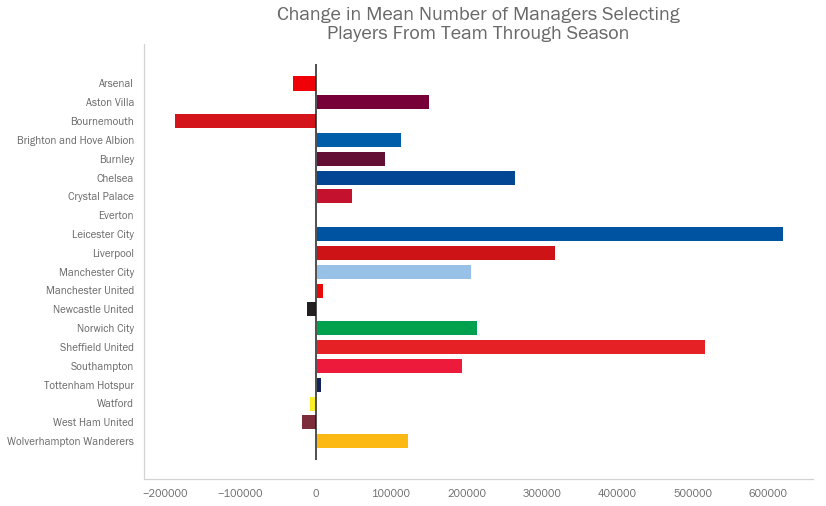

In [53]:
df_active = df_players.loc[df_players['CommentName'].isin(active_players)]
gw_select = df_active.groupby(['Team','GameWeek']).mean()

plt.figure(figsize=(12,8))

teams = list(df_players['Team'].unique())

Y = []
for i in teams:
    Y.append(gw_select.loc[i,'SelectedBy'][25] - gw_select.loc[i,'SelectedBy'][1])
    
X = range(1,len(Y)+1)
c = [i[1] for i in team_colors.items()]

plt.vlines(0,0,21)
plt.barh(X[::-1],Y,color=c)

plt.yticks(np.arange(1,21),labels=teams[::-1])
plt.xlabel('')
plt.title('Change in Mean Number of Managers Selecting\nPlayers From Team Through Season');

## Match Data

In the previous data gathering workbook, we collected a lot of match level data. Let's see if there are any key visual takeaways.

Firstly, let's import the data.

In [54]:
c = conn.cursor()
df_matches = sql('SELECT * FROM TeamMatchesDetail', c)
df_matches.sort_values('MatchID', inplace=True)
df_matches.head()

,TableIndex,MatchID,ForTeam,AgainstTeam,RelativeStrength,GameWeek,Home,Possession,Goals,ShotsOnTarget,...,Headers,ShotsCentre,ShotsLeft,ShotsRight,ShotsInBoxConceded,CloseShotsConceded,HeadersConceded,ShotsCentreConceded,ShotsLeftConceded,ShotsRightConceded
TeamMatchesDetailID,,,,,,,,,,,,,,,,,,,,,
1,0,46605,Liverpool,Norwich City,3,1,Home,57.9,4,7,...,2,6,2,2,7,7,1,4,3,1
2,1,46605,Norwich City,Liverpool,-3,1,Away,42.1,1,5,...,1,4,3,1,10,9,2,6,2,2
3,2,46606,Bournemouth,Sheffield United,0,1,Home,52.9,1,3,...,1,4,1,1,2,4,0,2,0,0
4,3,46606,Sheffield United,Bournemouth,0,1,Away,47.1,1,3,...,0,2,0,0,6,4,1,4,1,1
558,3,46606,Sheffield United,Bournemouth,1,1,Away,47.1,1,3,...,0,2,0,0,6,4,1,4,1,1


## Team performance
There are clearly a number of ways that we could look at this data. Firstly, let's just get a view of the 'average' performance of each team across all the matches that they have played so far.

### Goals

The aim of a game of football is, lest anyone forget, to score goals. Which teams have been best at this?

In [55]:
df_teams

,TeamID,Team,ShortName,Strength,CommentName,TeamColor
TeamsBasicID,,,,,,
1,1,Arsenal,ARS,4,Arsenal,#EF0107
2,2,Aston Villa,AVL,2,Aston Villa,#770038
3,3,Bournemouth,BOU,3,Bournemouth,#D3151B
4,4,Brighton,BHA,3,Brighton and Hove Albion,#005DAA
5,5,Burnley,BUR,3,Burnley,#630F33
6,6,Chelsea,CHE,4,Chelsea,#034694
7,7,Crystal Palace,CRY,3,Crystal Palace,#C4122E
8,8,Everton,EVE,3,Everton,#274488
9,9,Leicester,LEI,4,Leicester City,#0053A0


In [56]:
def add_spaces(text):
    '''
    Adds spaces before capital letters in a camel case string
    '''
    
    return re.sub(r"(\w)([A-Z])", r"\1 \2", text)

def team_df_generator(home='both', gameweeks=None, agg='mean', kpi=None):
    
    '''
    Creates an aggregated view of team performance,
    and returns the dataframe (with all KPIs)
    '''
    
    df_temp = df_matches.iloc[:,2:]
    
    #Strip out gameweeks / away-home splits as required
    if gameweeks!=None:
        df_temp = df_temp.loc[df_temp['GameWeek'].isin(gameweeks)]
    if home!='both':
        df_temp = df_matches.loc[df_matches['Home']==home]
    
    #Do the aggregation
    if agg=='mean':
        df_temp = df_temp.groupby('ForTeam').mean()
    elif agg=='sum':
        df_temp = df_temp.groupby('ForTeam').sum()
    elif agg=='median':
        df_temp = df_temp.groupby('ForTeam').median()
    elif agg=='std':
        df_temp = df_temp.groupby('ForTeam').std()
    elif agg=='max':
        df_temp = df_temp.groupby('ForTeam').max()
    elif agg=='min':
        df_temp = df_temp.groupby('ForTeam').min()
        
    if kpi==None:
        return df_temp
    else:
        return df_temp[kpi]
    

def team_bar(kpi, title=None, home='both', gameweeks=None,
             agg='mean', size=(10,7), order=True):
    
    '''
    Creates a one KPI bar chart, ordering
    '''
        
    if title==None:
        kpi_label = add_spaces(kpi)
        if home=='both':
            title=f'{agg.title()} {kpi_label} Per Game'
        else:
            title=f'{agg.title()} {kpi_label} Per Game at {home}'

    df_temp = team_df_generator(home=home,
                                gameweeks=gameweeks, agg=agg)
    df_temp = df_temp.sort_values(kpi, ascending=order)

    Y = df_temp[kpi][::-1]
    X = range(1,len(Y)+1)
    L = df_temp.index
    c = [df_teams.loc[df_teams['CommentName']==i,'TeamColor'].item()
         for i in L][::-1]

    plt.figure(figsize=(size))
    plt.barh(X[::-1],Y,color=c)

    for i, v in enumerate(Y[::-1]):
        plt.text(v + 0.02, i + 0.75, str(round(v,2)), fontsize=14)

    plt.yticks(np.arange(1,21),labels=L)
    plt.xlabel('')
    plt.xticks([])
    sns.despine(bottom=True)
    plt.title(title);

We see, unsurprisingly, that Manchester City and Liverpool who scored for fun in the 2018/19 season have continued their form, and have been outscoring every other team without exception.

It's worth noting that Leicester have also been very impressive, and are less than 0.2 goals per game behind Liverpool.

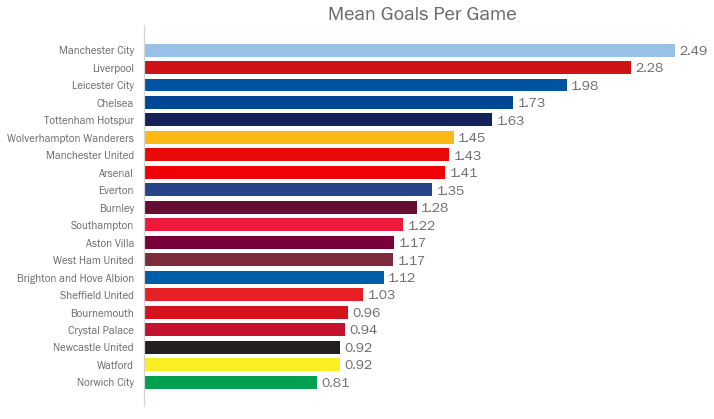

In [57]:
team_bar('Goals')

Of course, it's no good scoring a bunch of goals down one end of the field, if you are conceding more at the other. Which teams have had the meanest defences in the league?

Norwich City and Aston Villa, both promoted from the lower league, have had difficulties keeping the goals out. At the other end of the table, Liverpool have been very strong defensively, as have Sheffield United (who were also promoted to the Premiership, though have coped better with the transition).

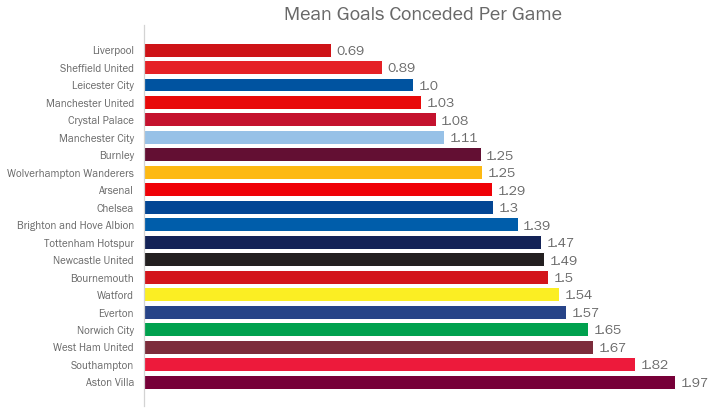

In [58]:
team_bar('GoalsConceded', order=False)

In [59]:
def team_scatter(x,y,c=None,s=400,size=(8,8),labels=True,
                 title=None,xlabel=None,ylabel=None):
    '''
    Takes an X and Y (use team_df_generator) and creates a scatter
    as required
    '''
    if type(x) == str:
        X = team_df_generator()[x]
    else:
        X = x
        
    if type(y) == str:
        Y = team_df_generator()[y]
    else:
        Y = y
    
    
    if type(s) == int:
        S = [s for i in X]
        
    #Fetch team colours
    L = list(X.index)
    if c==None:
        c = [df_teams.loc[df_teams['CommentName']==i,'TeamColor'].item()
             for i in L]
        
    plt.figure(figsize=(size))
    plt.scatter(X,Y,c=c,s=s)
    
    if labels==True:
        for i in L:
            x_text = X[i]
            y_text = Y[i]
            short_name = df_teams.loc[df_teams['CommentName']==i,'ShortName'].item()
            plt.text(x_text, y_text, short_name,
                     fontsize=10, color = 'white', ha = 'center', va = 'center')
    
    plt.title(title)
    try:
        if xlabel==None:
            plt.xlabel(add_spaces(x))
        else: 
            plt.xlabel(xlabel)
    except:
        pass

    try:
        if ylabel==None:
            plt.ylabel(add_spaces(y))
        else:
            plt.ylabel(ylabel)
    except:
        pass

We can plot this as a scatter - any team below the line is scoring more than they're conceding, and vice versa.

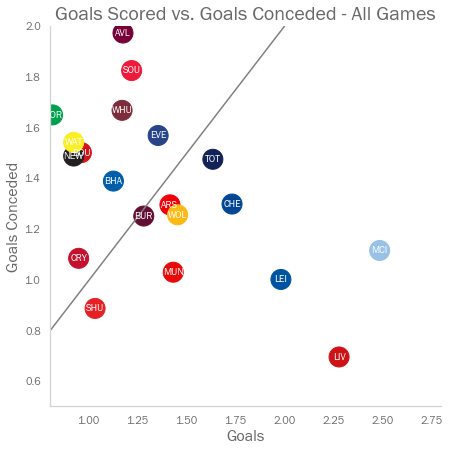

In [60]:
team_scatter('Goals','GoalsConceded',size=(7,7),
             title='Goals Scored vs. Goals Conceded - All Games')
plt.plot([0,3],[0,3], color='grey')
plt.xlim(0.8,2.8)
plt.ylim(0.5,2);

Of course, we can look at this picture for home and away matches, to see if this makes any difference.

Interestingly, it really seems like being away from home can make a significant difference to how many goals a team scores. Norwich, in particular, score less than half a goal away from home every match.

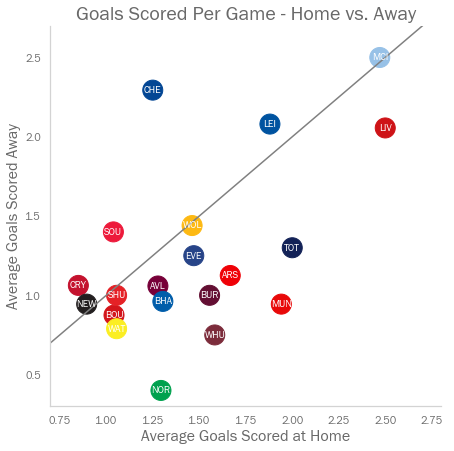

In [61]:
team_scatter(team_df_generator('Home')['Goals'],
             team_df_generator('Away')['Goals'],
             size=(7,7),
             xlabel='Average Goals Scored at Home',
             ylabel='Average Goals Scored Away',
             title='Goals Scored Per Game - Home vs. Away')
plt.plot([0,3],[0,3], color='grey')
plt.xlim(0.7,2.8)
plt.ylim(0.3,2.7);

This is also true for goals conceded - teams are conceding up to twice as much away from home.

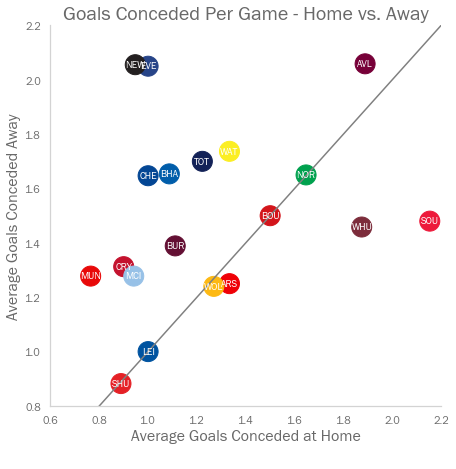

In [90]:
team_scatter(team_df_generator('Home')['GoalsConceded'],
             team_df_generator('Away')['GoalsConceded'],
             size=(7,7),
             xlabel='Average Goals Conceded at Home',
             ylabel='Average Goals Conceded Away',
             title='Goals Conceded Per Game - Home vs. Away')
plt.plot([0,3],[0,3], color='grey')
plt.xlim(0.6,2.2)
plt.ylim(0.8,2.2);

We can also get a view of performance as the season has gone on.

For example, Chelsea were scoring 2.2 goals per game in the first third of the season have gone on to score only 1.1 in the second.

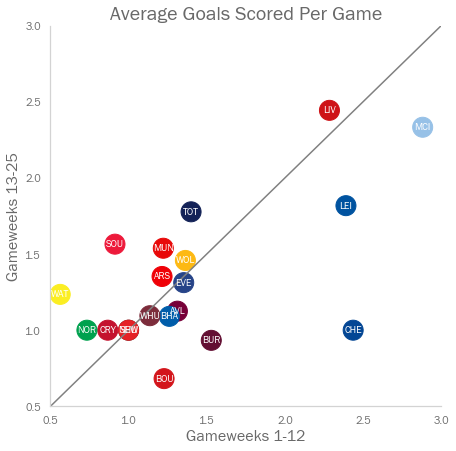

In [63]:
team_scatter(team_df_generator(gameweeks=range(1,13), kpi='Goals'),
             team_df_generator(gameweeks=range(13,26), kpi='Goals'),
             size=(7,7),
             xlabel='Gameweeks 1-12',
             ylabel='Gameweeks 13-25',
             title='Average Goals Scored Per Game')
plt.plot([0,3],[0,3], color='grey')
plt.xlim(0.5,3)
plt.ylim(0.5,3);

We can also see significant improvements from some teams in defence - in particular, Norwich, Watford, and Southampton are each conceding something like one fewer goal per game than they were.

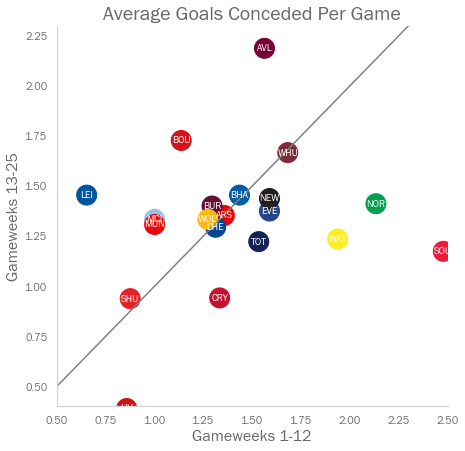

In [64]:
team_scatter(team_df_generator(gameweeks=range(1,13), kpi='GoalsConceded'),
             team_df_generator(gameweeks=range(13,26), kpi='GoalsConceded'),
             size=(7,7),
             xlabel='Gameweeks 1-12',
             ylabel='Gameweeks 13-25',
             title='Average Goals Conceded Per Game')
plt.plot([0,3],[0,3], color='grey')
plt.xlim(0.5,2.5)
plt.ylim(0.4,2.3);

We can also look at shot profligacy - how often were teams actually able to convert chances?

(Note the line below represents the average conversion rate - about 11%).

In [65]:
df_matches['Goals'].sum() / df_matches['TotalShots'].sum()

0.10845771144278607

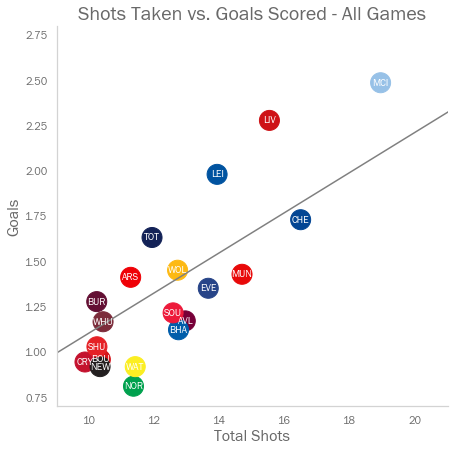

In [66]:
team_scatter('TotalShots','Goals',size=(7,7),
             title='Shots Taken vs. Goals Scored - All Games')
plt.plot([0,100],[0,11.06], color='grey')
plt.xlim(9,21)
plt.ylim(0.7,2.8);

We see that the league's top scorers have this position due to their better conversion. Teams like Watford and Wolves are having the same number of shots in games, yet Wolves are converting twice as many of these shots into goals

In [67]:
df_matches['ShotsOnTarget'].sum() / df_matches['TotalShots'].sum()

0.3515422885572139

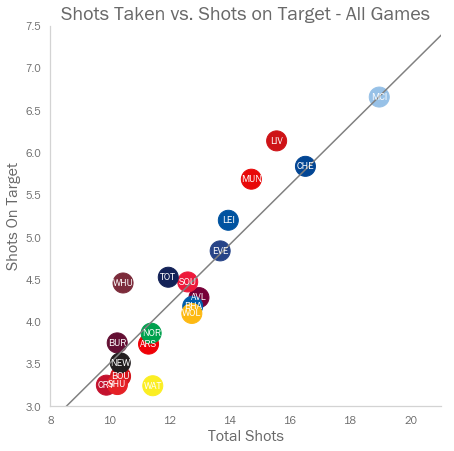

In [68]:
team_scatter('TotalShots','ShotsOnTarget',size=(7,7),
             title='Shots Taken vs. Shots on Target - All Games')
plt.plot([0,100],[0,35.18], color='grey')
plt.xlim(8,21)
plt.ylim(3,7.5);

### Team Possession

Possession of the ball is key - you can't take shots if you don't have the ball!

However, different styles of the game have developed that place a lower emphasis on having the ball. This is employed by lower teams, who perhaps hope to score goals on the counterattack, having soaked up pressure from the opposition.

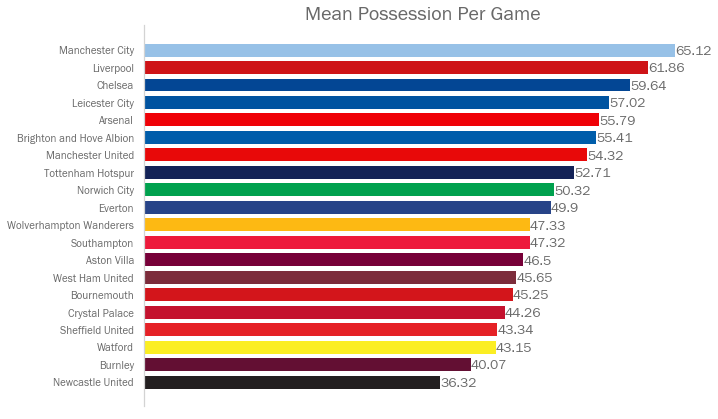

In [69]:
team_bar('Possession')

We see that there is a clear correlation between possession of the ball and shots taken in a match, though the correlation is less clear when we compare possession and actual goals scored.

Wolves (and, to a degree, Liverpool) appear to be very clinical with the ball, scoring more goals than their possession statistics might suggest.

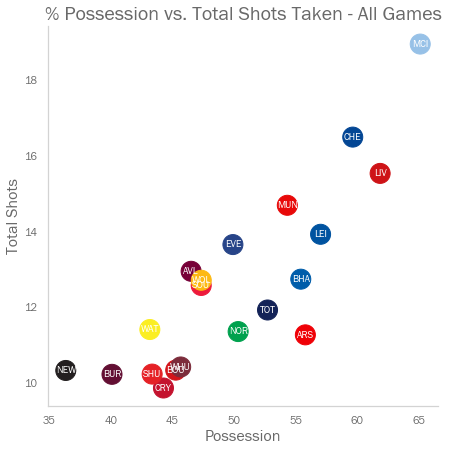

In [70]:
team_scatter('Possession','TotalShots',size=(7,7),
             title='% Possession vs. Total Shots Taken - All Games')

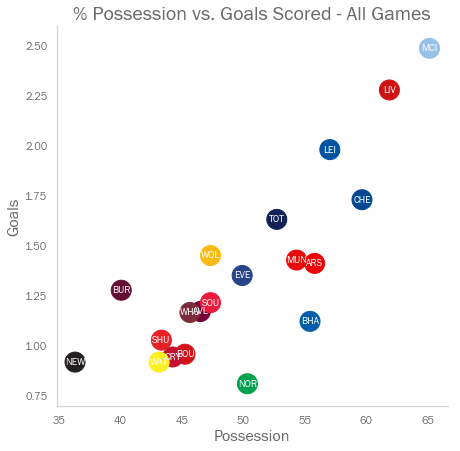

In [71]:
team_scatter('Possession','Goals',size=(7,7),
             title='% Possession vs. Goals Scored - All Games')

### Shot Positions

Of course, not all shots are created equal. We can see how many shots are being taken from where.

Let's load in the shot detail dataframe.

In [72]:
c = conn.cursor()
df_shots = sql('SELECT * FROM ShotsDetail', c)
df_shots.head()

,TableIndex,MatchID,GameWeek,Player,ForTeam,AgainstTeam,RelativeStrength,Time,ShotOutcome,AssistedBy,ShotType,ShotPosition,ShotSide,Close
ShotsDetailID,,,,,,,,,,,,,,
1,0,46605,1,Teemu Pukki,Norwich City,Liverpool,-3,64,Goal,Emiliano Buendia,right footed shot,the box,the centre,close
2,1,46605,1,Divock Origi,Liverpool,Norwich City,3,42,Goal,Trent Alexander-Arnold,header,the box,the centre,close
3,2,46605,1,Virgil van Dijk,Liverpool,Norwich City,3,28,Goal,Mohamed Salah,header,the box,the centre,close
4,3,46605,1,Mohamed Salah,Liverpool,Norwich City,3,19,Goal,Roberto Firmino,left footed shot,the box,the right,close
5,4,46605,1,Moritz Leitner,Norwich City,Liverpool,-3,62,Woodwork,Todd Cantwell,right footed shot,the box,the right,close


There are a couple of things we can explore right away, for example, when are shots most likely to be taken?

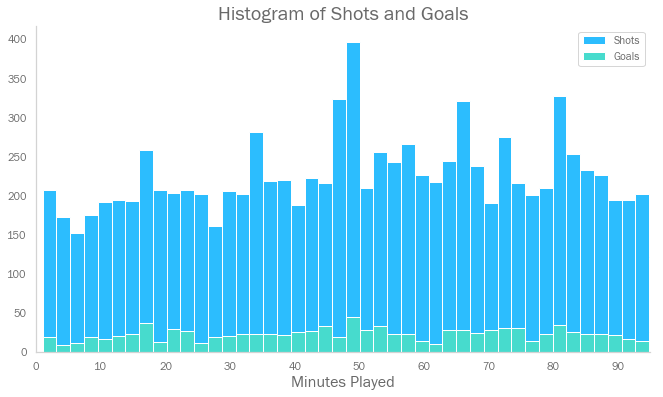

In [73]:
plt.figure(figsize=(11,6))

df_temp = df_shots['Time'].map(lambda x: (int(x[:2])+int(x[-1]))
                     if ('+' in x) else int(x))
plt.hist(df_temp, bins=45, label='Shots')

df_temp = df_shots.loc[df_shots['ShotOutcome']=='Goal','Time'].map(
    lambda x: (int(x[:2])+int(x[-1]))
    if ('+' in x) else int(x))
plt.hist(df_temp, bins=45, label='Goals')

plt.xticks(np.arange(0,105,10))
plt.xlim(0,95)
plt.legend()
plt.title('Histogram of Shots and Goals')
plt.xlabel('Minutes Played');

So we can see spikes of shots (and goals) around 20 minutes, half time, and the 80 minute mark.

We now create a series of functions that will draw a football field, and allow us to see how the shot KPIs vary across the different areas of the field.

In [74]:
def pos_color_dict_creator(series, grad=CB91_Grad_WV,
                           outliers=None, stretch=1, factor=1):
    
    '''
    Takes a shot level series, and outputs a
    dictionary of unique areas. The dictionary values
    are tuples of form (hexcolor, numerical value)
    '''
    #Declare all posible positions
    positions = ['a difficult anglethe left',
             'a difficult anglethe right',
             'long rangeN/A',
             'long rangethe centre',
             'long rangethe left',
             'long rangethe right',
             'outside the boxN/A',
             'penaltyN/A',
             'the boxthe centre',
             'the boxthe left',
             'the boxthe right',
             'the six yard boxthe left',
             'the six yard boxthe right',
             'very close rangeN/A']
    #Get a count of these from the series, filling in 0s where no shots
    count = [series.get(i,0) for i in positions]
    
    #Pass this count through the gradient mapper function
    colors = gradient_mapper(np.array(count), grad=grad, outliers=outliers,
                             stretch=stretch, factor=factor)[0]
    
    #Create tuples
    color_tuples = list(zip(colors, count))
    
    #Return this as a dictionary of positions and appropriate colors
    #e.g. {'a': ('#a', 1), 'b': ('#b', 2)... }
    return dict(zip(positions, color_tuples))


def penalty_curve(x,z):
    '''
    Takes x values and a radius, and retuns the required
    y values to draw the penalty arc on a football pitch
    '''
    return ((10/z)**2-(x-(30/z))**2)**0.5 + 12/z


def draw_pitch(z=6,lw=7,lc='white'):
    
    '''
    Uses matplotlib functions to draw a football pitch
    '''
    plt.figure(figsize=(60/z, 50/z))

    #Pitch
    plt.fill_between([0,60/z], [0,0], [50/z,50/z], color=CB91_GreenL)
    plt.plot(np.array([0,0,60,60,0])/z, np.array([0,50,50,0,0])/z,
             lw=lw, c=lc)

    #18 yard box
    plt.plot(np.array([8,8,52,52])/z, np.array([0,18,18,0])/z,
             lw=lw, c=lc)
    #6 yard box
    plt.plot(np.array([20,20,40,40])/z, np.array([0,6,6,0])/z,
             lw=lw, c=lc)
    #Penalty spot
    pen_spot = plt.Circle((30/z, 12/z), 0.3, color=lc)
    plt.gcf().gca().add_artist(pen_spot)

    #Penalty curve
    pen_x = np.arange(22/z,38/z,0.1/z)
    pen_y = [penalty_curve(i,z) for i in pen_x]
    plt.plot(pen_x, pen_y, lw=lw, c=lc)

    sns.despine(left=True, bottom=True)
    plt.xticks([])
    plt.yticks([]);
    

def pitch_heatmap(pos_color_dict,
                  z=6,lw=3,lc='dimgrey',
                  alpha=0.8,labels=True,
                  fs=14,fc='#444444'):
    '''
    Takes a dictionary of areas and colors,
    and draws a heatmap of the pitch to show these areas.
    '''
    
    #Draw the pitch
    draw_pitch(z=z,lw=lw,lc=lc)

    #Difficult angle, left
    plt.fill_between([40/z,52/z], [0,0], [6/z,6/z], alpha=alpha,
                     color=pos_color_dict.get('a difficult anglethe right', None)[0])
    #Difficult angle, right
    plt.fill_between([8/z,20/z], [0,0], [6/z,6/z], alpha=alpha,
                     color=pos_color_dict.get('a difficult anglethe left', None)[0])

    #Very close range
    plt.fill_between([20/z,40/z], [0,0], [3/z,3/z], alpha=alpha,
                     color=pos_color_dict.get('very close rangeN/A', None)[0])
    #6 yard box, left
    plt.fill_between([20/z,30/z], [3/z,3/z], [6/z,6/z], alpha=alpha,
                     color=pos_color_dict.get('the six yard boxthe right', None)[0])
    #6 yard box, right
    plt.fill_between([30/z,40/z], [3/z,3/z], [6/z,6/z], alpha=alpha,
                     color=pos_color_dict.get('the six yard boxthe left', None)[0])

    #The box, left
    plt.fill_between([8/z,22/z], [6/z,6/z], [18/z,18/z], alpha=alpha,
                     color=pos_color_dict.get('the boxthe right', None)[0])
    #The box, centre
    plt.fill_between([22/z,38/z], [6/z,6/z], [18/z,18/z], alpha=alpha,
                     color=pos_color_dict.get('the boxthe centre', None)[0])
    #The box, right
    plt.fill_between([38/z,52/z], [6/z,6/z], [18/z,18/z], alpha=alpha,
                     color=pos_color_dict.get('the boxthe left', None)[0])

    #Outside the box
    plt.fill_between([8/z,52/z], [18/z,18/z], [27/z,27/z], alpha=alpha,
                     color=pos_color_dict.get('outside the boxN/A', None)[0])
    #Penalty spot
    pen_shade = plt.Circle((30/z, 12/z), 0.25, alpha=alpha,
                         color=pos_color_dict.get('penaltyN/A', None)[0])
    plt.gcf().gca().add_artist(pen_shade)

    #LR left
    plt.fill_between([0/z,8/z], [0/z,0/z], [35/z,35/z], alpha=alpha,
                     color=pos_color_dict.get('long rangethe right', None)[0])
    #LR centre
    plt.fill_between([8/z,52/z], [27/z,27/z], [35/z,35/z], alpha=alpha,
                     color=pos_color_dict.get('long rangethe centre', None)[0])
    #LR right
    plt.fill_between([52/z,60/z], [0/z,0/z], [35/z,35/z], alpha=alpha,
                     color=pos_color_dict.get('long rangethe left', None)[0])
    #LR N/A
    plt.fill_between([0,60/z], [35/z,35/z], [50/z,50/z], alpha=alpha,
                     color=pos_color_dict.get('long rangeN/A', None)[0]);
    
    if labels==True:
        plt.text(46/z,3/z,pos_color_dict.get('a difficult anglethe right', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(14/z,3/z,pos_color_dict.get('a difficult anglethe left', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        
        plt.text(30/z,1.5/z,pos_color_dict.get('very close rangeN/A', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(25/z,4.5/z,pos_color_dict.get('the six yard boxthe right', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(35/z,4.5/z,pos_color_dict.get('the six yard boxthe left', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        
        plt.text(15/z,12/z,pos_color_dict.get('the boxthe right', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(30/z,15.5/z,pos_color_dict.get('the boxthe centre', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(45/z,12/z,pos_color_dict.get('the boxthe left', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        
        plt.text(30/z,24/z,pos_color_dict.get('outside the boxN/A', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(30/z,12/z,pos_color_dict.get('penaltyN/A', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        
        plt.text(4/z,17.5/z,pos_color_dict.get('long rangethe right', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(30/z,31/z,pos_color_dict.get('long rangethe centre', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(56/z,17.5/z,pos_color_dict.get('long rangethe left', None)[1],
            ha='center',va='center',fontsize=fs,color=fc)
        plt.text(30/z,42.5/z,pos_color_dict.get('long rangeN/A', None)[1],
            ha='center',va='center',fontsize=fs,color=fc);
        
        
def shot_count_heatmap(forteam=None,outcomes=None,
                       againstteam=None,
                       players=None,title=None,
                       gw=list(range(33)),
                       z=7,lw=3,lc='dimgrey',alpha=0.8,
                       grad=CB91_Grad_WG,outliers='top',
                       stretch=3, factor=2, labels=True,
                       fs=14,fc='#444444'):
    '''
    Takes a list of teams and a list of shot outcomes, and returns
    a heatmap of the shots that apply to those parameters
    '''
    #Populate all variables as required
    all_teams = list(df_shots['ForTeam'].unique())
    if forteam==None:
        forteam=all_teams
    if againstteam==None:
        againstteam=all_teams  
    if outcomes==None:
        outcomes=list(df_shots['ShotOutcome'].unique())
    if players==None:
        players=list(df_shots['Player'].unique())
    
    #Ensure that everything is a list
    if type(forteam)!=list:
        forteam = [forteam]
    if type(againstteam)!=list:
        againstteam = [againstteam]        
    if type(outcomes)!=list:
        outcomes = [outcomes] 
    if type(gw)!=list:
        gw = [gw]
    
    #Create the temporary dataframe of shots
    df_temp = df_shots.loc[(df_shots['ForTeam'].isin(forteam))
                      &(df_shots['AgainstTeam'].isin(againstteam))                      
                      &(df_shots['ShotOutcome'].isin(outcomes))
                      &(df_shots['Player'].isin(players))
                      &(df_shots['GameWeek'].isin(gw))]
    
    #Create the exact positions of the shots
    df_temp['Position'] = df_temp['ShotPosition'] + df_temp['ShotSide']
    
    #Create the series that we'll use for the colors
    temp_series = df_temp.groupby('Position').count()['Player']
    temp_dict = pos_color_dict_creator(temp_series,grad=grad,
                                       outliers=outliers,
                                       stretch=stretch, factor=factor)
    
    #Draw the heatmap
    pitch_heatmap(temp_dict,z=z,lw=lw,lc=lc,alpha=alpha,
                  labels=labels,fs=fs,fc=fc)
    
    plt.title(title)

We can start using these functions to start looking at the shots taken (and converted to goals) from the top teams, and see how this compares against the bottom teams.

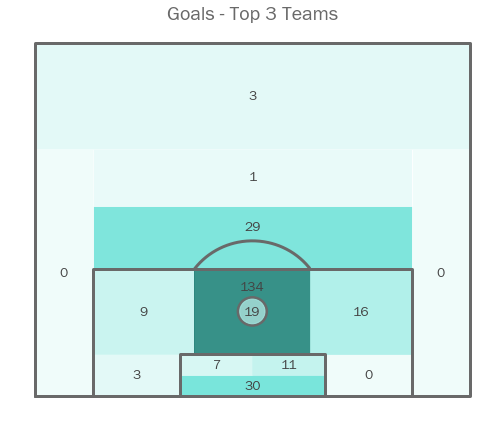

In [75]:
shot_count_heatmap(['Liverpool','Manchester City','Leicester City'],
                  outcomes='Goal', title='Goals - Top 3 Teams')

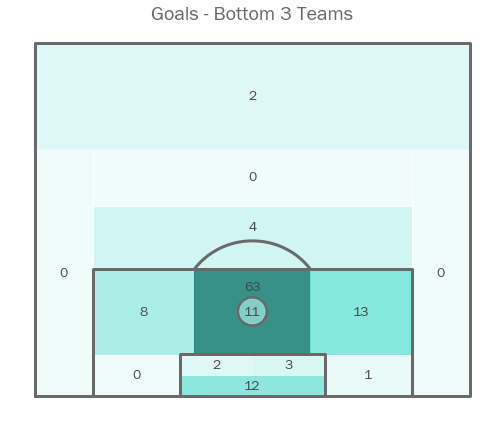

In [76]:
shot_count_heatmap(['West Ham United','Norwich City','Watford'],
                  outcomes='Goal', title='Goals - Bottom 3 Teams')

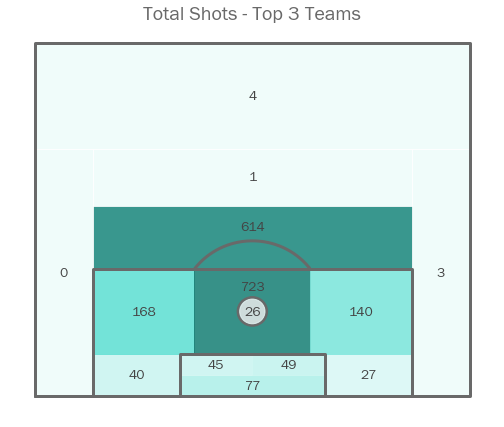

In [77]:
shot_count_heatmap(['Liverpool','Manchester City','Leicester City'],
                  title='Total Shots - Top 3 Teams')

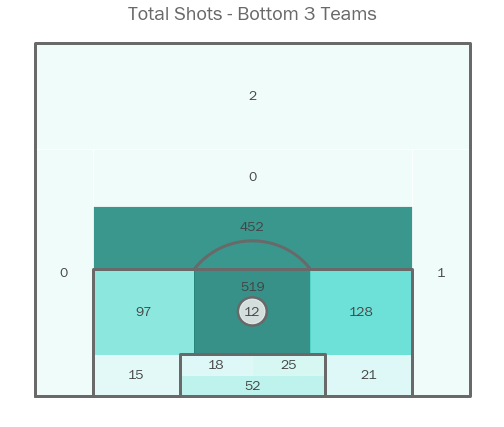

In [78]:
shot_count_heatmap(['West Ham United','Norwich City','Watford'],
                  title='Total Shots - Bottom 3 Teams', grad=CB91_Grad_WG)

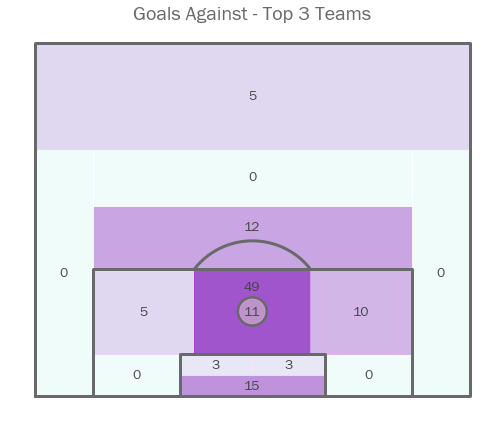

In [79]:
shot_count_heatmap(againstteam=['Liverpool','Manchester City','Leicester City'],
                  outcomes='Goal', title='Goals Against - Top 3 Teams',
                  grad=CB91_Grad_WP)

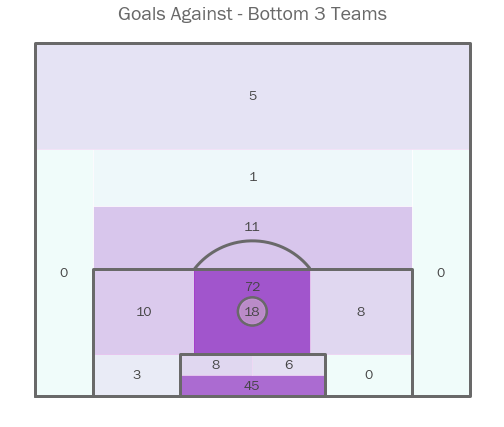

In [80]:
shot_count_heatmap(againstteam=['West Ham United','Norwich City','Watford'],
                  outcomes='Goal', title='Goals Against - Bottom 3 Teams',
                  grad=CB91_Grad_WP)

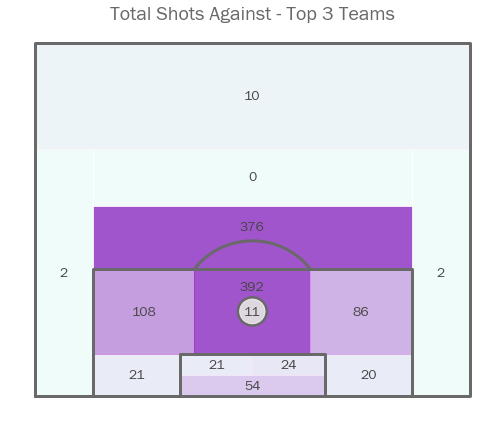

In [81]:
shot_count_heatmap(againstteam=['Liverpool','Manchester City','Leicester City'],
                   title='Total Shots Against - Top 3 Teams', grad=CB91_Grad_WP)

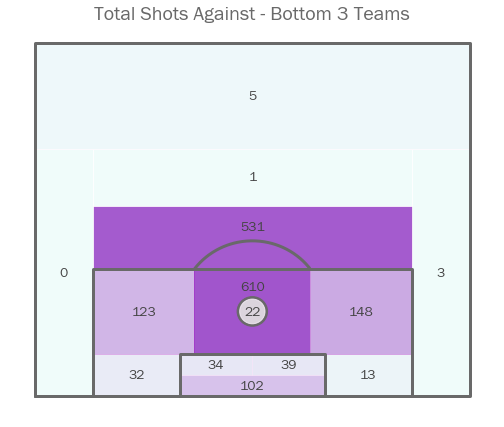

In [82]:
shot_count_heatmap(againstteam=['West Ham United','Norwich City','Watford'],
                   title='Total Shots Against - Bottom 3 Teams', grad=CB91_Grad_WP)

### Shot Quality

We can see that there are patches on the field that have a lot of shots, but low conversion to goals - for example the shots just outside the box, which account for a very high share of total shots, but a low share of goals. We can get a sense of this by looking specifically at KPIs such as shot acccuracy by pitch location.

We create a new dataframe to store these statistics.

In [83]:
#Create the categories (shot locations)
df_shots['ShotLocation'] = df_shots['ShotPosition'] + df_shots['ShotSide']
df_shot_pos = df_shots.groupby('ShotLocation').count()[['TableIndex']]
df_shot_pos.columns = ['TotalShots']

#Create the total on target
df_shot_pos['OnTarget'] = df_shots.loc[df_shots['ShotOutcome'].isin(
    ['Goal','Saved'])].groupby(
    'ShotLocation').count()[['TableIndex']]

#Create the total goals
df_shot_pos['Goals'] = df_shots.loc[df_shots['ShotOutcome']=='Goal'].groupby(
    'ShotLocation').count()[['TableIndex']]

#Fill in NAs
df_shot_pos.fillna(0, inplace=True)

#Create ratios
df_shot_pos['%OnTarget'] = df_shot_pos['OnTarget'] / df_shot_pos['TotalShots']
df_shot_pos['%Goals'] = df_shot_pos['Goals'] / df_shot_pos['TotalShots']
df_shot_pos['%OnTargetGoals'] = df_shot_pos['Goals'] / df_shot_pos['OnTarget']

df_shot_pos

,TotalShots,OnTarget,Goals,%OnTarget,%Goals,%OnTargetGoals
ShotLocation,,,,,,
a difficult anglethe left,166,67,8.0,0.403614,0.048193,0.119403
a difficult anglethe right,123,49,3.0,0.398374,0.024390,0.061224
long rangeN/A,46,28,26.0,0.608696,0.565217,0.928571
long rangethe centre,3,3,1.0,1.000000,0.333333,0.333333
long rangethe left,17,6,0.0,0.352941,0.000000,0.000000
long rangethe right,5,2,0.0,0.400000,0.000000,0.000000
outside the boxN/A,3458,884,96.0,0.255639,0.027762,0.108597
penaltyN/A,84,82,65.0,0.976190,0.773810,0.792683
penaltythe centre,1,1,0.0,1.000000,0.000000,0.000000


We can create series from these stats, and visualise them on the pitch.

In [84]:
ot_series = round(df_shot_pos['%OnTarget']*100,1)
ot_colors = pos_color_dict_creator(ot_series, CB91_Grad_WG)

goals_series = round(df_shot_pos['%Goals']*100,1)
goals_colors = pos_color_dict_creator(goals_series, CB91_Grad_WG)

ot_goals_series = round(df_shot_pos['%OnTargetGoals']*100,1)
ot_goals_colors = pos_color_dict_creator(ot_goals_series, CB91_Grad_WG)

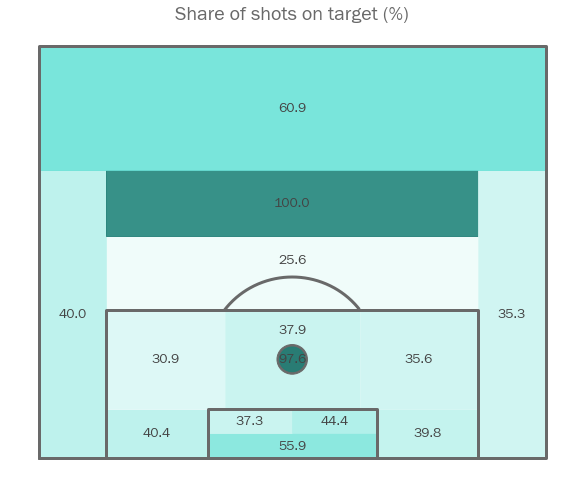

In [85]:
pitch_heatmap(ot_colors)
plt.title('Share of shots on target (%)');

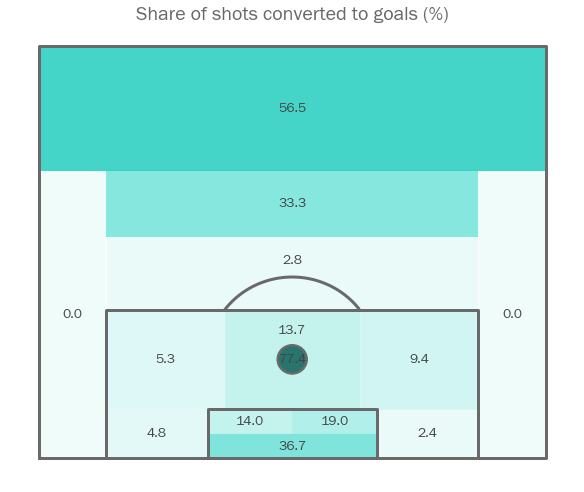

In [86]:
pitch_heatmap(goals_colors)
plt.title('Share of shots converted to goals (%)');

The long range shots are outliers (especially given that we only have 40 such shots, compared to thousands from other positions). However, we can see that shots are not created equally. Generally, proximity to the goal is a good indicator as to whether your shot is going to be on target. However, we can see that goal conversion rates are wildly different - nearly 4 in 10 shots are goals if taken from very close proximity, compared to less than 3 in 100 if taken from a difficult angle. As we would expect, penalties are frequently converted into goals, although these are pretty hard to account for in a model, since they are relatively rare events.